In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# 1. Loading the data

In [3]:
train_data, test_data = tf.keras.datasets.mnist.load_data(path="mnist.npz")
x_train = train_data[0].reshape(-1,784).astype(float) / 255
y_train = train_data[1]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


label is 9
(28, 28)


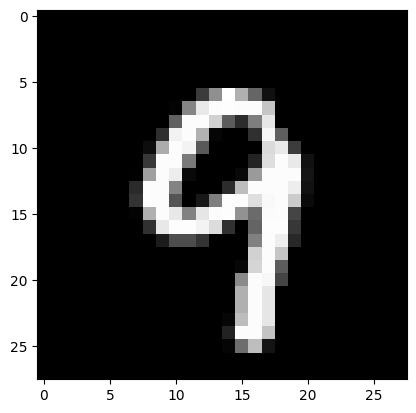

In [4]:
# exploring the data
i = np.random.randint(y_train.size)

print("label is", y_train[i])
plt.imshow(train_data[0][i], cmap='gray')
print(train_data[0][1].shape)

# 2. Building the model

We use Keras to build a fully-connected neural network.

For more details, see https://keras.io/guides/training_with_built_in_methods/

In [5]:
# source : https://keras.io/guides/training_with_built_in_methods/

def build_model():
    inputs = keras.Input(shape=(784,), name="digits")
    x = layers.Dense(32, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(32, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
    return model

model = build_model()

loss = keras.losses.sparse_categorical_crossentropy

model.summary()

Model: "mnist_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ digits (InputLayer)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │          25,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predictions (Dense)                  │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,506 (103.54 KB)

 Trainable params: 26,506 (103.54 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# untrained model
predicted_probas = model(x_train)
y_pred = np.argmax(predicted_probas, 1) # the prediction is the class with highest probability
y_pred[0:30]

array([8, 2, 1, 0, 2, 2, 2, 2, 0, 2, 0, 7, 6, 1, 6, 2, 1, 0, 1, 6, 6, 2,
       2, 0, 8, 2, 6, 9, 0, 2])

In [7]:
# what we would like to get
y_train[0:30]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7], dtype=uint8)

# 3. Computing gradients

We are now going to implement the stochastic gradient method using the Keras functionalities.

First, we need to understand how to compute gradients using auto-differentation (also called **backpropagation**).

In [8]:
# Source: https://keras.io/guides/writing_a_custom_training_loop_in_tensorflow/

# Example of gradient computation using automatic differentiation

# selecting a batch
x_train_batch = x_train[:8]
y_train_batch = y_train[:8]

# Open a GradientTape to record the operations run
# during the forward pass, which enables auto-differentiation.
with tf.GradientTape() as tape:
        # Run the forward pass of the layer.
        # The operations that the layer applies
        # to its inputs are going to be recorded
        # on the GradientTape.

        logits = model(x_train_batch)  # Logits for this minibatch (the logits are the name we give to the Neural Network output)

        # Compute the loss value for this minibatch.
        loss_value = loss(y_train_batch, logits)

# Use the gradient tape to automatically retrieve
# the gradients of the trainable variables with respect to the loss.
grad = tape.gradient(loss_value, model.trainable_weights)

We also define two important helper functions.

In [9]:
## update the weights by adding real_factor * update
def update_weights(model, update, real_factor = 1.):
    new_weights = model.trainable_weights.copy()

    # iterate over all layers
    for i in range(len(new_weights)):
        new_weights[i] = new_weights[i] + real_factor * update[i]

    model.set_weights(new_weights)


# Evaluate model
def mean_loss(model, X, Y):
    logits = model(X)
    return np.mean(loss(Y, logits))

In [10]:
# evaluating the train loss on the whole dataset
# this is a costly operation, use sparsely
mean_loss(model, x_train, y_train)

2.3153431

### Question 4.1

- La première couche cachée comporte 32 cellules pour une entrée de taille 784. Ce qui correspond à : $784 \times 32 = 25088$ poids auxquels on ajoute 32 biais. Ce qui fait 25120 coefficients à entraîner.

- La seconde couche cachée comporte 32 cellules pour une entrée de taille 32. Ce qui correspond à : $32 \times 32 = 1024$ poids auxquels on ajoute 32 biais. Ce qui fait 1056 coefficients à entraîner.

- La dernière couche comporte 10 cellules pour une entrée de taille 32. Ce qui correspond à : $10 \times 32 = 320$ poids auxquels on ajoute 10 biais. Ce qui fait 330 coefficients à entraîner.

Au total, 26506 coefficients sont à optimiser.

# 4. Training the model

### Question 5.1

In [11]:
# Stochastic gradient algorithm
def SGD(model, x_train, y_train, learning_rate, epochs=1, batch_size=1,trace=True):
    it = []  # Liste pour les itérations
    err = []  # Liste pour les erreurs
    for epoch in range(epochs):
        for i in range(0, x_train.shape[0], batch_size):
            x_train_batch = x_train[i:i+batch_size]
            y_train_batch = y_train[i:i+batch_size]
            with tf.GradientTape() as tape:
                logits = model(x_train_batch)
                loss_value = loss(y_train_batch, logits)
            grad = tape.gradient(loss_value, model.trainable_weights)
            update_weights(model, grad, -learning_rate/batch_size)
            if trace:
              if i % 1000 == 0:
                  it.append(i + epoch * x_train.shape[0])  # Index global des itérations
                  err.append(mean_loss(model, x_train, y_train))  # Calcul de l'erreur moyenne
    return model, it, err

In [137]:
# initialize model
model = build_model()

_,it01,err01 = SGD(model, x_train, y_train, 0.01, epochs=1, batch_size=1,trace=False)
#model = build_model()

#_,it01,err1 = SGD(model, x_train, y_train, 3, epochs=1, batch_size=30)
#model = build_model()

#_,it01,err001 = SGD(model, x_train, y_train, 0.003, epochs=1, batch_size=30)

KeyboardInterrupt: 

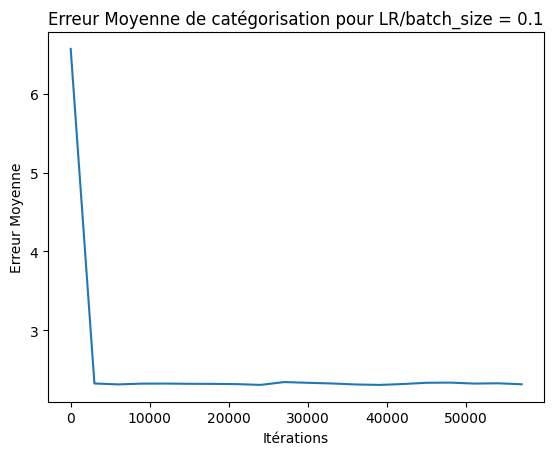

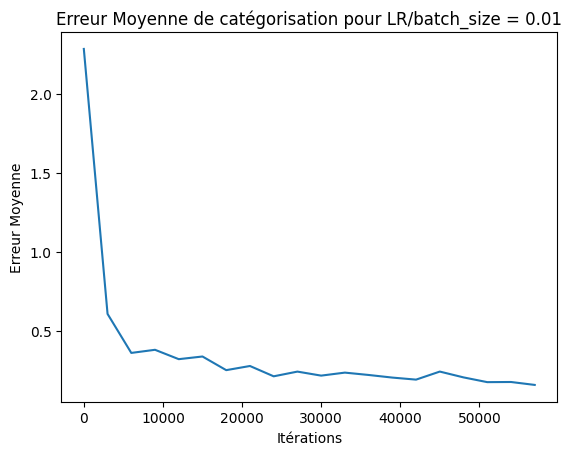

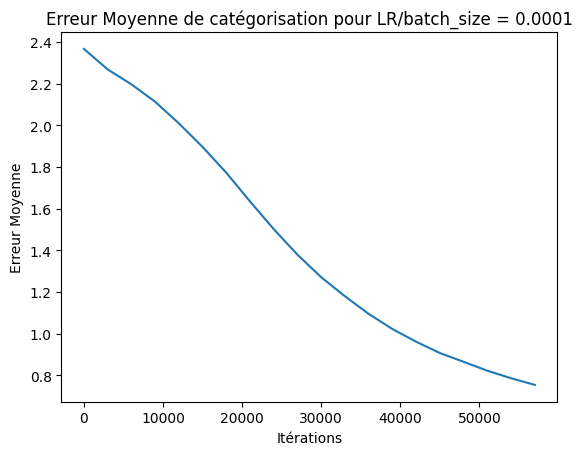

In [88]:
plt.plot(it01,err1)
plt.title("Erreur Moyenne de catégorisation pour LR/batch_size = 0.1")
plt.xlabel("Itérations")
plt.ylabel("Erreur Moyenne")
plt.show()

plt.plot(it01,err01)
plt.title("Erreur Moyenne de catégorisation pour LR/batch_size = 0.01")
plt.xlabel("Itérations")
plt.ylabel("Erreur Moyenne")
plt.show()

plt.plot(it01,err001)
plt.title("Erreur Moyenne de catégorisation pour LR/batch_size = 0.0001")
plt.xlabel("Itérations")
plt.ylabel("Erreur Moyenne")
plt.show()

Plus le pas ```learning_rate``` est faible plus la convergence est **régulière**. Mais un pas trop petit entraîne une convergence très lente. Aussi, un pas de convergence trop important entraîne la divergence de l'algorithme : l'erreur d'entraînement ne baisse que très peu et reste bloqué à un palier, très éloigné de l'erreur atteinte avec un pas optimal.

# 6. Empirical risk minimization

In [68]:
model2 = build_model()
_,it01_5,err01_5 = SGD(model2, x_train, y_train, 0.03, epochs=5, batch_size=30,trace=False)

### Question 6.2

En utilisant plusieurs exemples dans un batch, on obtient une **meilleure approximation de la vraie direction des gradients** (celle calculée sur l’ensemble du dataset). Cela réduit les oscillations et favorise une convergence plus régulière. Cela réduit aussi **le temps de calcul** car on a besoin de moins d'itérations et le modèle généralise plus facilement.

### Question 6.3

Le code **Question 5.1** implémente déjà le mini-batching.

Utiliser le minibatching permet d'accélérer grandement la convergence et de diminuer le temps de calcul. La régularité de la convergence est même améliorée.

# 7. Comparison & Evaluation of the models

In [1]:
x_test = test_data[0].reshape(-1,784).astype(float) / 255
y_test = test_data[1]

NameError: name 'test_data' is not defined

Modèle 1 : ```1 epoch```, ```batch_size = 1```

In [138]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [139]:
loss, acc = model.evaluate(x_train, y_train, batch_size=1)
print("\nAccuracy on the training set: %.1f%%" % (100.0 * acc))

60000/60000 ━━━━━━━━━━━━━━━━━━━━ 64s 1ms/step - accuracy: 0.9392 - loss: 0.2073

Accuracy on the training set: 94.0%


In [140]:
loss, acc = model.evaluate(x_test, y_test, batch_size=1)
print("\nAccuracy on the test set: %.1f%%" % (100.0 * acc))

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.9274 - loss: 0.2385

Accuracy on the test set: 93.8%


Modèle 2 : ```5 epoch```, ```batch_size = 30```

In [107]:
model2.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [108]:
loss, acc = model2.evaluate(x_train, y_train, batch_size=20)
print("\nAccuracy on the training set: %.1f%%" % (100.0 * acc))

3000/3000 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9247 - loss: 0.2610

Accuracy on the training set: 92.5%


In [110]:
loss, acc = model2.evaluate(x_test, y_test, batch_size=20)
print("\nAccuracy on the test set: %.1f%%" % (100.0 * acc))

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9137 - loss: 0.2969

Accuracy on the test set: 92.4%


Les scores sur les sets d'entraînements et de tests sont très proches preuve que le modèle généralise bien. De plus on remarque que le modèle entraîné sur plusieurs epoch donne un meilleur résultat à ```batch_size```constant.